In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

In [2]:
from datetime import datetime, timedelta

In [3]:
import re

In [4]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2023-02-06 22:30:26.977775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [7]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def create_model(input_shape=(64, 64, 15)):

    depths=[3, 3, 27, 3]
    projection_dims=[32, 64, 96, 128]
    drop_path_rate=0.0
    layer_scale_init_value=1e-6


    model_name='Branch64X'
    IN64 = layers.Input(shape=input_shape)
    X = IN64
    # ----- convnext block 0 ----- #

    X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

    for j in range(depths[0]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                                   groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext


    # ----- convnext block 1 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

    for j in range(depths[1]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                                   groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    # ----- convnext block 2 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

    for j in range(depths[2]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=5, padding="same",
                                   groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    # ----- convnext block 3 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

    for j in range(depths[3]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=5, padding="same",
                                   groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    V1 = X

    OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
#     OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

#     OUT = layers.Dense(64, name="{}_dense1".format(model_name))(OUT)
#     OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
#     OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

#     OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

    model = Model(inputs=IN64, outputs=OUT, name=model_name)
    
    return model


In [8]:
def create_model_head():

    
    IN_vec = keras.Input((128,))    
    X = IN_vec
    #
    X = keras.layers.Dense(64)(X)
    X = keras.layers.Activation("relu")(X)
    X = keras.layers.BatchNormalization()(X)
    
    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=IN_vec, outputs=OUT)
    
    return model

In [9]:
def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [10]:
#ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
L_vars = len(ind_pick_from_batch)

In [11]:
vers = ['v3', 'v4x', 'v4']
leads = [2, 3, 4, 5, 6, 20, 21, 22, 23]
filenames_pos = {}
filenames_neg = {}

for ver in vers:
    for lead in leads:
        if ver == 'v3' and lead < 23:
            path_ = '/glade/scratch/ksha/DATA/NCAR_batch_v3/'
        elif ver == 'v3' and lead == 23:
            path_ = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'
        else:
            path_ = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v4x/'
            
        filenames_pos['{}_lead{}'.format(ver, lead)] = sorted(glob("{}*pos*lead{}.npy".format(path_, lead)))
        filenames_neg['{}_lead{}'.format(ver, lead)] = sorted(glob("{}*neg_neg_neg*lead{}.npy".format(path_, lead)))
        
        print('{}, lead{}, pos: {}, neg: {}'.format(ver, lead, 
                                                    len(filenames_pos['{}_lead{}'.format(ver, lead)]), 
                                                    len(filenames_neg['{}_lead{}'.format(ver, lead)])))



v3, lead2, pos: 5510, neg: 887822
v3, lead3, pos: 4297, neg: 889035
v3, lead4, pos: 3242, neg: 890090
v3, lead5, pos: 2565, neg: 891795
v3, lead6, pos: 2127, neg: 891205
v3, lead20, pos: 5407, neg: 887925
v3, lead21, pos: 6711, neg: 887649
v3, lead22, pos: 7613, neg: 886747
v3, lead23, pos: 8009, neg: 886351
v4x, lead2, pos: 1995, neg: 348553
v4x, lead3, pos: 1618, neg: 349958
v4x, lead4, pos: 1218, neg: 350358
v4x, lead5, pos: 962, neg: 350614
v4x, lead6, pos: 817, neg: 349731
v4x, lead20, pos: 1777, neg: 344659
v4x, lead21, pos: 2209, neg: 344227
v4x, lead22, pos: 2511, neg: 343925
v4x, lead23, pos: 2690, neg: 343746
v4, lead2, pos: 1995, neg: 348553
v4, lead3, pos: 1618, neg: 349958
v4, lead4, pos: 1218, neg: 350358
v4, lead5, pos: 962, neg: 350614
v4, lead6, pos: 817, neg: 349731
v4, lead20, pos: 1777, neg: 344659
v4, lead21, pos: 2209, neg: 344227
v4, lead22, pos: 2511, neg: 343925
v4, lead23, pos: 2690, neg: 343746


In [12]:
def name_extract(filenames):
    
    date_base = datetime(2020, 7, 14)
    
    filename_train = []
    filename_valid = []
    
    base_v3_s = datetime(2018, 7, 15)
    base_v3_e = datetime(2020, 12, 2)

    base_v4_s = datetime(2020, 12, 3)
    base_v4_e = datetime(2022, 7, 15)

    base_ref = datetime(2010, 1, 1)
    
    date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
    date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+365+30)]
    
    base_ref = datetime(2019, 10, 1)
    date_list_v4x = [base_ref + timedelta(days=day) for day in range(429)]
    
    for i, name in enumerate(filenames):
        
        if 'v4x' in name:
            date_list = date_list_v4x
        elif 'v4' in name:
            date_list = date_list_v4
        else:
            date_list = date_list_v3
        
        nums = re.findall(r'\d+', name)
        day = int(nums[-4])
        day = date_list[day]
        
        if (day - date_base).days > 0:
            filename_valid.append(name)
        else:
            filename_train.append(name)

        
    return filename_train, filename_valid

In [13]:
filenames_pos_train = {}
filenames_neg_train = {}

filenames_pos_valid = {}
filenames_neg_valid = {}

for ver in vers:
    for lead in leads:
        temp_namelist_pos = filenames_pos['{}_lead{}'.format(ver, lead)]
        temp_namelist_neg = filenames_neg['{}_lead{}'.format(ver, lead)]
        
        pos_train, pos_valid = name_extract(temp_namelist_pos)
        neg_train, neg_valid = name_extract(temp_namelist_neg)
        
        print('pos train: {} pos valid: {} neg train: {} neg valid {}'.format(len(pos_train), 
                                                                              len(pos_valid), 
                                                                              len(neg_train), 
                                                                              len(neg_valid)))
        
        filenames_pos_train['{}_lead{}'.format(ver, lead)] = pos_train
        filenames_neg_train['{}_lead{}'.format(ver, lead)] = neg_train
        
        filenames_pos_valid['{}_lead{}'.format(ver, lead)] = pos_valid
        filenames_neg_valid['{}_lead{}'.format(ver, lead)] = neg_valid

pos train: 4874 pos valid: 636 neg train: 743510 neg valid 144312
pos train: 3803 pos valid: 494 neg train: 744581 neg valid 144454
pos train: 2888 pos valid: 354 neg train: 745496 neg valid 144594
pos train: 2295 pos valid: 270 neg train: 747117 neg valid 144678
pos train: 1888 pos valid: 239 neg train: 746496 neg valid 144709
pos train: 4637 pos valid: 770 neg train: 743747 neg valid 144178
pos train: 5779 pos valid: 932 neg train: 743633 neg valid 144016
pos train: 6595 pos valid: 1018 neg train: 742817 neg valid 143930
pos train: 6960 pos valid: 1049 neg train: 742452 neg valid 143899
pos train: 1470 pos valid: 525 neg train: 226746 neg valid 121807
pos train: 1203 pos valid: 415 neg train: 227013 neg valid 122945
pos train: 912 pos valid: 306 neg train: 227304 neg valid 123054
pos train: 727 pos valid: 235 neg train: 227489 neg valid 123125
pos train: 601 pos valid: 216 neg train: 226587 neg valid 123144
pos train: 1141 pos valid: 636 neg train: 221935 neg valid 122724
pos train: 

In [14]:
pos_train_all = []
neg_train_all = []
pos_valid_all = []
neg_valid_all = []

for ver in vers:
    for lead in leads:
        pos_train_all += filenames_pos_train['{}_lead{}'.format(ver, lead)]
        neg_train_all += filenames_neg_train['{}_lead{}'.format(ver, lead)]
        pos_valid_all += filenames_pos_valid['{}_lead{}'.format(ver, lead)]
        neg_valid_all += filenames_neg_valid['{}_lead{}'.format(ver, lead)]

In [15]:
# filename_valid = neg_valid_all[::200] + pos_valid_all[::20]
# print(len(filename_valid))

# L_valid = len(filename_valid)

# VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
# VALID_target = np.ones(L_valid)

# for i, name in enumerate(filename_valid):
#     data = np.load(name)
#     for k, c in enumerate(ind_pick_from_batch):
        
#         VALID_input_64[i, ..., k] = data[..., c]

#         if 'pos' in name:
#             VALID_target[i] = 1.0
#         else:
#             VALID_target[i] = 0.0
            
# save_dir = '/glade/work/ksha/NCAR/'
# tuple_save = (VALID_input_64, VALID_target)
# label_save = ['VALID_input_64', 'VALID_target']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CNN_Validation.hdf')

In [16]:
save_dir = '/glade/work/ksha/NCAR/'

with h5py.File(save_dir+'CNN_Validation.hdf', 'r') as h5io:
    VALID_input_64 = h5io['VALID_input_64'][...]
    VALID_target = h5io['VALID_target'][...]

In [17]:
flag_train = 'base'

if flag_train == 'head':
    flag_weights = 'base'
else:
    flag_weights = 'head'
    
weights_round = 3


In [18]:
save_round = 4

In [19]:
model_head = create_model_head()

# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/HY_Lead4/')
# model_head.set_weights(W_old)

model_base = create_model(input_shape=(64, 64, 15))

# W_new = model_base.get_weights()
# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE2_peak_{}{}/'.format(flag_weights, weights_round))

# for i in range(len(W_new)):
#     if W_new[i].shape == W_old[i].shape:
#         W_new[i] = W_old[i]
#     else:
#         ewraewthws
        
# model_base.set_weights(W_new)

# if flag_train == 'base':
#     for layer in model_head.layers: 
#         layer.trainable = False
# elif flag_train == 'head':
#     for layer in model_base.layers: 
#         layer.trainable = False

2023-02-06 22:39:15.810245: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-06 22:39:15.894946: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-06 22:39:15.964243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-06 22:39:15.964306: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-06 22:39:16.160534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-06 22:39:16.160609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [20]:
IN = layers.Input(shape=(64, 64, 15))

VEC = model_base(IN)
OUT = model_head(VEC)

model_final = Model(inputs=IN, outputs=OUT)

In [21]:
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE2_peak_base{}/'.format(weights_round))
model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
model_final.set_weights(W_old)

In [22]:
# if flag_train == 'base':
#     for layer in model_head.layers: 
#         layer.trainable = False
# elif flag_train == 'head':
#     for layer in model_base.layers: 
#         layer.trainable = False

In [23]:
# Y_pred = model_final.predict([VALID_input_64])
# record_temp = verif_metric(VALID_target, Y_pred)
# 0.025381361192679055 0.025381361192679055

In [24]:
Y_pred = model_final.predict([VALID_input_64])
record_temp = verif_metric(VALID_target, Y_pred)

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2023-02-06 22:39:56.594386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-06 22:39:56.603221: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-02-06 22:39:57.492235: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-02-06 22:40:01.672235: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


0.025381361192679055


In [64]:
# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE1_15p_base/')
# model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
# model_final.set_weights(W_old)

# Y_pred = model_final.predict([VALID_input_64])
# record_temp = verif_metric(VALID_target, Y_pred)

In [25]:
# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE1_15p_full/')
# model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
# model_final.set_weights(W_old)

# Y_pred = model_final.predict([VALID_input_64])
# record_temp = verif_metric(VALID_target, Y_pred)

#0.03020596704790702

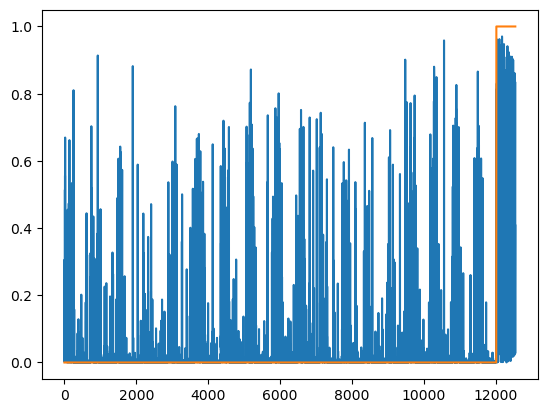

In [26]:
plt.plot(Y_pred)
plt.plot(VALID_target)

In [ ]:
seeds = 1567 #3725 #

min_del = 0
max_tol = 100 # early stopping with patience

epochs = 500
batch_size = 200
L_train = 64 #int(len(TRAIN_Y_pick) / batch_size)

X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
Y_batch[...] = np.nan

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# =========== Model Section ========== #
key = 'RE2_peak_{}{}'.format(flag_train, save_round)
model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

filename_pos_train = pos_train_all
filename_neg_train = neg_train_all
# ========== Training loop ========== #
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = 0.025381361192679055 #record_temp #0.01840167896363949 #record_temp
print("Initial record: {}".format(record))

set_seeds(seeds)
    
for i in range(epochs):
    start_time = time.time()

    # loop of batch
    for j in range(L_train):
        if flag_train == 'base':
            N_pos = 20
        else:
            N_pos = 20
            
        N_neg = batch_size - N_pos

        ind_neg = du.shuffle_ind(L_neg)
        ind_pos = du.shuffle_ind(L_pos)

        file_pick_neg = []
        for ind_temp in ind_neg[:N_neg]:
            file_pick_neg.append(filename_neg_train[ind_temp])

        file_pick_pos = []
        for ind_temp in ind_pos[:N_pos]:
            file_pick_pos.append(filename_pos_train[ind_temp])

        file_pick = file_pick_neg + file_pick_pos

        if len(file_pick) != batch_size:
            sregwet

        for k in range(batch_size):
            data = np.load(file_pick[k])

            for l, c in enumerate(ind_pick_from_batch):
                temp = data[..., c] 
                X_batch_64[k, ..., l] = temp

            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer

        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        Y_batch = Y_batch[ind_, :]

        # train on batch
        model_final.train_on_batch(X_batch_64, Y_batch);

    # epoch end operations
    Y_pred = model_final.predict([VALID_input_64])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1

    record_temp = verif_metric(VALID_target, Y_pred)

    # if i % 10 == 0:
    #     model.save(model_path_backup)

    if (record - record_temp > min_del):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model_final.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        if record_temp >= 2.0:
            print('Early stopping')
            break;
        else:
            tol += 1
            if tol >= max_tol:
                print('Early stopping')
                break;
            else:
                continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 0.025381361192679055
0.050928234788087015
Validation loss 0.050928234788087015 NOT improved
0.035830217564023735
Validation loss 0.035830217564023735 NOT improved
0.15686110721093474
Validation loss 0.15686110721093474 NOT improved
0.08388915151130705
Validation loss 0.08388915151130705 NOT improved
0.05402034775642441
Validation loss 0.05402034775642441 NOT improved
0.03391364605022714
Validation loss 0.03391364605022714 NOT improved
0.026455330067437582
Validation loss 0.026455330067437582 NOT improved
0.028470090720532148
Validation loss 0.028470090720532148 NOT improved
0.027773308493713813
Validation loss 0.027773308493713813 NOT improved
0.035973426163035796
Validation loss 0.035973426163035796 NOT improved
0.044587372584949575
Validation loss 0.044587372584949575 NOT improved
0.028392321555793645
Validation loss 0.028392321555793645 NOT improved
0.025731075028943708
Validation loss 0.025731075028943708 NOT improved
0.028541844013524154
Validation loss 0.028541844

2023-02-07 01:30:34.539697: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE2_peak_base4/assets
--- 588.7541449069977 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.043146021074874724
Validation loss 0.043146021074874724 NOT improved
0.029422821547687234
Validation loss 0.029422821547687234 NOT improved
0.027814085249640998
Validation loss 0.027814085249640998 NOT improved
0.033355395412343614
Validation loss 0.033355395412343614 NOT improved
0.03039553582365139
Validation loss 0.03039553582365139 NOT improved
0.029408926239520034
Validation loss 0.029408926239520034 NOT improved
0.04154766433452567
Validation loss 0.04154766433452567 NOT improved
0.025914200359796816
Validation loss 0.025914200359796816 NOT improved
0.03202315989973407
Validation loss 0.03202315989973407 NOT improved
0.03236201987766385
Validation loss 0.03236201987766385 NOT improved
0.03598588467923756
Validation loss 0.03598588467923756 NOT improved
0.05896090217522406
Validation loss 0.05896090217522406 NOT improved
0.02719855290620364
Validation loss 0.02719855290620364 NOT improved
0.048604497883192155
Validation loss 0.048604497883192155 NOT improved
0.02579566414331953


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.032974685021543014
Validation loss 0.032974685021543014 NOT improved
0.02581137755610152
Validation loss 0.02581137755610152 NOT improved
0.028339838791869378
Validation loss 0.028339838791869378 NOT improved
0.0254914315082837
Validation loss 0.0254914315082837 NOT improved
0.028666031580964285
Validation loss 0.028666031580964285 NOT improved
0.025550395439021045
Validation loss 0.025550395439021045 NOT improved
0.026735763087303164
Validation loss 0.026735763087303164 NOT improved
0.025121921298773005
Validation loss improved from 0.025155936328926598 to 0.025121921298773005
save to: /glade/work/ksha/NCAR/Keras_models/RE2_peak_base4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE2_peak_base4/assets
--- 586.0942621231079 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.02606716024929731
Validation loss 0.02606716024929731 NOT improved
0.027795030259643135
Validation loss 0.027795030259643135 NOT improved
0.025192945821420055
Validation loss 0.025192945821420055 NOT improved
0.04018593820147683
Validation loss 0.04018593820147683 NOT improved
0.025128964409923467
Validation loss 0.025128964409923467 NOT improved
0.025402993499574845
Validation loss 0.025402993499574845 NOT improved
0.03516998848177207
Validation loss 0.03516998848177207 NOT improved
0.02667199923724573
Validation loss 0.02667199923724573 NOT improved
0.02606189055015402
Validation loss 0.02606189055015402 NOT improved
0.04773291410130897
Validation loss 0.04773291410130897 NOT improved
0.0259970752090809
Validation loss 0.0259970752090809 NOT improved
0.033590655452554054
Validation loss 0.033590655452554054 NOT improved
0.02543304101227028
Validation loss 0.02543304101227028 NOT improved
0.02551640359733227
Validation loss 0.02551640359733227 NOT improved
0.027882228181121793
Valid

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04335491668273447
Validation loss 0.04335491668273447 NOT improved
0.024981248764997497
Validation loss improved from 0.025042731288274837 to 0.024981248764997497
save to: /glade/work/ksha/NCAR/Keras_models/RE2_peak_base4
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE2_peak_base4/assets
--- 772.8346672058105 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04554646796207383
Validation loss 0.04554646796207383 NOT improved
0.034160160629486326
Validation loss 0.034160160629486326 NOT improved
0.025115976091176183
Validation loss 0.025115976091176183 NOT improved
0.029026605209700063
Validation loss 0.029026605209700063 NOT improved
0.027604635919806178
Validation loss 0.027604635919806178 NOT improved
0.0540869172051559
Validation loss 0.0540869172051559 NOT improved
0.02863165050673855
Validation loss 0.02863165050673855 NOT improved
0.025653274868033638
Validation loss 0.025653274868033638 NOT improved
0.032193088986599935
Validation loss 0.032193088986599935 NOT improved
0.03470945177867482
Validation loss 0.03470945177867482 NOT improved
0.03265893190931978
Validation loss 0.03265893190931978 NOT improved
0.027615747120822712
Validation loss 0.027615747120822712 NOT improved
0.02830116089251647
Validation loss 0.02830116089251647 NOT improved
0.02534325202475828
Validation loss 0.02534325202475828 NOT improved
0.025113354492252854
V

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.02747124913378732
Validation loss 0.02747124913378732 NOT improved
0.04814169368311827
Validation loss 0.04814169368311827 NOT improved
0.03833858043767481
Validation loss 0.03833858043767481 NOT improved
0.026970369435180813
Validation loss 0.026970369435180813 NOT improved
0.025261802878948216
Validation loss 0.025261802878948216 NOT improved
0.032049907881353604
Validation loss 0.032049907881353604 NOT improved
0.025700361527970124
Validation loss 0.025700361527970124 NOT improved
0.02514876234575588
Validation loss 0.02514876234575588 NOT improved
0.03646421760319337
Validation loss 0.03646421760319337 NOT improved
0.04083318877190914
Validation loss 0.04083318877190914 NOT improved
0.025209279083489418
Validation loss 0.025209279083489418 NOT improved


In [ ]:
plt.plot(Y_pred)